# _eggplant_ : an introduction
<br>

* Author: [Alma Andersson](https://twitter.com/aalmaander)
* Purpose: originally designed for the [SCOG](https://www.singlecell.de/index.php/events/scog-virtual-workshop-spatial-transcriptomics-data-analysis-in-python/) workshop 2022-05-24
* Created: 2022-05-17

Welcome to the `eggplant` session, here we'll explore some of the most basic features of _[eggplant](https://github.com/almaan/eggplant)_. A method and python package to transfer information from different spatial-omics sections to a single reference (common coordinate framework). 


**How does the method work?** (brief)<br>
<br>
The method is more thoroughly described in it’s associated [manuscript](https://www.biorxiv.org/content/10.1101/2021.11.11.468178v1?rss=1), but to briefly outline the five main steps, we will use the same flowchart as is presented in Figure 1A (of the above referenced manuscript).

![eggplant five steps](https://spatial-eggplant.readthedocs.io/en/latest/_images/flow.png)



1. Construct/choose a reference that you want to transfer information to, choose samples to transfer information from.
2. Chart the landmarks, i.e., annotate common landmarks in both the reference and observed data.
3. Select feature of interest, e.g., expression of your favorite gene
4. Learn a transfer function relating landmark distances to expression
5. Transfer information to the reference, apply the transfer function to each location in the reference

To elaborate a bit more on the flow of information from observed data to the reference we refer to the image below.

![flow of information](https://spatial-eggplant.readthedocs.io/en/latest/_images/fullflow.png)

We start by creating a distance matrix $X$ for the observed data, containing the distance from every observation to each landmark. Next, we also create the feature vector containing the values for our feature of interest at each location. We model $y$ as a function ($f$) of $X$ and assume that this function is distributed according to a Gaussian Process, and may thus fit it accordingly (using Gaussian Process Regression).

To transfer the information, we first create a similar distance matrix to
$X$ but for all of the locations in our _reference_, this is denoted $\bar{X}$. Finally, we apply the (learnt) function $f$ to $\bar{X}$, rendering a new feature vector $\bar{y}$ which represents an estimate of the feature values at each of the reference locations.

**In this tutorial**<br>
<br>
In this tutorial we'll be looking at two different data sets, one of the developmental heart and one perturbation study (in the sense that there's a perturbation of the normal state) of the mouse brain. We'll use these two data sets to explore some of the most important aspects of `eggplant`, including:

- how to load a reference and the data from which information should be transferred
- how to assess the data and reference
- how to prepare the data for transfer
- how to conduct the information transfer, this will be done in two different ways:
 - one exact (but slightly slower) approach
 - one approximate (but _significantly_ faster) approach
- the creation of composite representations
- regional enrichment analysis
- spatial differential gene expression analysis (SDEA)

**Dictionary**<br>
- spot : spatial capture location
- information : any form of information associated with your spatial data, in this tutorial it's equivalent to _gene expression_.
- transfer (of information) : when information is cast into the common spatial domain (reference)
- reference : the spatial domain we want to transfer information _to_ (from the observed data)

**Comments**<br>
- The data and reference in this notebook have already had their landmarks annotated. This is _not_ a part of the `eggplant` package, thus when analyzing your own data, annotation is something you must do prior to the transfer.
- If you want more information about any of the functions used here, `eggplant` has a fairly extensive documentation on readthedocs, which you can access here: [https://spatial-eggplant.readthedocs.io/en/latest/eggplant.html](https://spatial-eggplant.readthedocs.io/en/latest/eggplant.html)

Start by loading the necessary packages/modules

I think you need python 3.9 for it, as it is required for numpy 1.20.0 which is required for eggplant's installation process apparently

In [4]:
!python --version

Python 3.8.12


In [2]:
#!pip install numpy spatial-eggplant

In [3]:
import eggplant as eg
import numpy as np

import os.path as osp
from PIL import Image
import pandas as pd

from os import listdir, makedirs, unlink

import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc

import pickle

## Notebook setup

Before we begin with the actual analysis, there are some variables for *you* to set. The first one is whether this notebook should be run as a demo (the analysis will not run until completion, instead pre-analyzed data will be loaded). Using the demo mode will give you an idea of the workflow without having to spend time waiting for the results. Set `DEMO=True` below to run this notebook in demo mode, to actually run all analyses, let `DEMO=False`.

In [4]:
DEMO = False

The second variable is `DEVICE`, indicating which device you want to use. If you have a cuda supported GPU, you can set `DEVICE="gpu"`, if not set this to `DEVICE="cpu"`. Both alternatives work, but it will take somewhat longer time to run the analysis on a cpu. 

In [5]:
DEVICE = "gpu"

The third variable for you to set is `SAVE_OBJS` - which indicates whether you want to save your results or not (even if you're not running in DEMO mode, you might not want to overwrite the pre-analyzed data). To prevent your results from being saved let `SAVE_OBJS = False`, otherwise set it to `True`.

In [6]:
SAVE_OBJS = False

The fourth, and final, variable indicates whether the data should be downloaded or not - if you've already downloaded the data once, set this to `False`.

In [7]:
DOWNLOAD_DATA = True

## Download data

All the necessary data can be downloaded from a OSF project ([link](https://osf.io/bdezp/)). The scripts below will do this automatically for you. The total size of all data is ~900MB, meaning it shouldn't take too long time to download, but you might have to wait a minute or two. 
<br>
<br>
**NOTE**: In case the automatic download below wouldn't work for you (potential risk for Windows users), you can also download and extract the data manually (using [this](https://osf.io/bdezp/) link). Just make sure that the extracted data folder is located at the relative (to this notebook) path `../data`. 

In [10]:
if DOWNLOAD_DATA:
    import subprocess
    import wget
    from sys import platform
    
    try:
        url = "https://osf.io/hst7p/download"
        pwd = "turing120623"
        print("Downloading zip file.")
        filename = wget.download(url, out = "../")
        print("Successful download. Extracting zip file.")
        if platform.startswith("win"):
            import zipfile
            with zipfile.ZipFile("../data.zip","r") as zf:
                zf.extractall("../",pwd =bytes(pwd,"utf-8"))
        else:
            subprocess.call(['unzip','-P',pwd,"../data.zip","-d","../"])
        print("Extraction complete. Removing zip file.")
        if osp.isfile("../data.zip"):
            unlink("../data.zip")
    except:
        print("Automatic data download was not successful. Try to manually download the data.")

100% [......................................................................] 924464284 / 924464284Successful download. Extracting zip file.
Archive:  ../data.zip
   creating: ../data/
   creating: ../data/human-developmental-heart/
   creating: ../data/human-developmental-heart/curated/
  inflating: ../data/human-developmental-heart/curated/V10S28-368_D1.h5ad  
  inflating: ../data/human-developmental-heart/curated/V10F24-105_B1.h5ad  
  inflating: ../data/human-developmental-heart/curated/V10S28-371_A1.h5ad  
  inflating: ../data/human-developmental-heart/curated/V10F24-105_C1.h5ad  
  inflating: ../data/human-developmental-heart/curated/V10F24-105_D1.h5ad  
  inflating: ../data/human-developmental-heart/curated/V10B01-014_A1.h5ad  
  inflating: ../data/human-developmental-heart/curated/V10F24-105_A1.h5ad  
   creating: ../data/human-developmental-heart/reference/
  inflating: ../data/human-developmental-heart/reference/reference.png  
  inflating: ../data/human-developmental-heart/r

## Developmental Heart Analysis

The first data set that we'll analyze is that of the developmental heart (dh). This data set was produced for the _eggplant_ publication/[manuscript](https://www.biorxiv.org/content/10.1101/2021.11.11.468178v1?rss=1). 

The data set consists of seven Visium sections of the developmental heart, all collected at PCW (post conceptional week) 10. Four of these sections belong to individual 0, while the three others belong to individual 1. Once we look at the associated HE-images, you will see how it's quite obvious which sections that "belong together". <br>
<br>
First we define some paths to the data and reference information.

In [11]:
# main directory for dh data
DH_MAIN_DIR = "../data/human-developmental-heart/"

# paths for dh count data
DH_DATA_PTHS = ["curated/V10F24-105_A1.h5ad",
                "curated/V10F24-105_B1.h5ad",
                "curated/V10F24-105_C1.h5ad",
                "curated/V10F24-105_D1.h5ad",
                "curated/V10B01-014_A1.h5ad",
                "curated/V10S28-368_D1.h5ad",
                "curated/V10S28-371_A1.h5ad",
            
           ]
DH_DATA_PTHS = [osp.join(DH_MAIN_DIR,p) for p in DH_DATA_PTHS]

# directory for reference information
DH_REF_DIR = osp.join(DH_MAIN_DIR,"reference")

# directory to save/load objects to/from
OBJ_DIR = "../data/analysis/"

Next, we'll **load the actual count data**. The data will be stored in a dictionary, and each sample will be given an informative name (the key in the dictionary). The sections will be referred to as "dhX" where "X" represents a letter from A-G.

In [12]:
# read anndata files containing charted count data
dh_adatas = [ad.read_h5ad(p) for p in DH_DATA_PTHS]
# create dictionary with informative names to hold the data
dh_adatas = {f"dh{l}":dh_adatas[k] for k,l in enumerate(["A","B","C","D","E","F","G"])}

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


We can inspect the data set by using one of `eggplant`'s plot functions `visualize_observed` from the `methods` (`fun`) module. We're not interested in any special feature (at this moment) so we set `features=None`. However, we want to see what the sample tissue looks like, and since this is Visium data we have an HE-image; to show the image we set `show_image = True`. The parameter `n_cols` determines the number of columns in the generated plot.

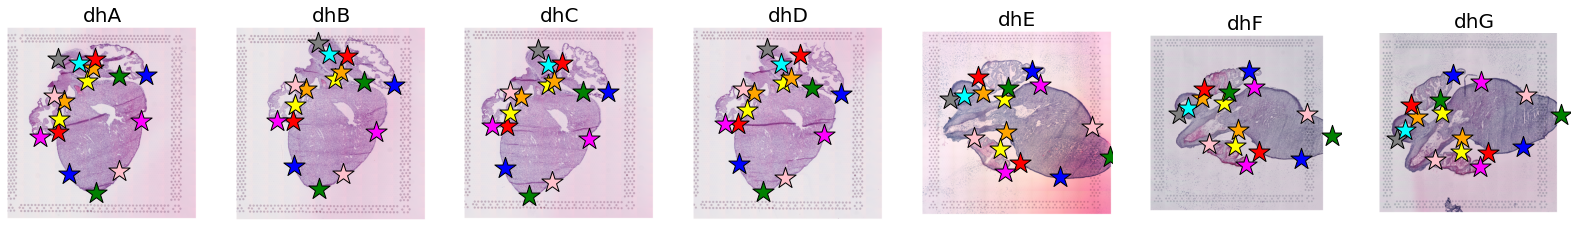

In [13]:
eg.pl.visualize_observed(dh_adatas,
                         features = None,
                         show_image =True,
                         n_cols = len(dh_adatas))

Having loaded the count data, we'll proceed to load the reference which we want to transfer information to. Both the image representing the reference (a `.png` file) and the landmark coordinates (a `.tsv` file) will be loaded in the cell below.

In [14]:
# load reference image
dh_ref_img = Image.open(osp.join(DH_REF_DIR,"reference.png"))
# load landmark coordinates
dh_ref_lmk = pd.read_csv(osp.join(DH_REF_DIR,"landmarks.tsv"),
                      sep="\t",
                      header = 0,
                      index_col=0)


We can have a look at the reference image and the landmarks, just to make sure that everything looks as expected.

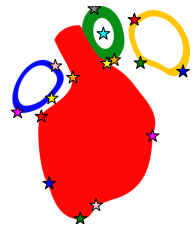

In [15]:
# create colormap for the landmarks
dh_lmk_cmap = eg.pl.ColorMapper(eg.C.LANDMARK_CMAP)
# plot reference image
plt.imshow(dh_ref_img)
# plot landmarks
plt.scatter(dh_ref_lmk.x_coord,
            dh_ref_lmk.y_coord,
            c = dh_lmk_cmap(dh_ref_lmk),
            edgecolor = "black",
            marker = "*",
            s = 180,
           )
# plot aesthetics
plt.axis("off")
plt.show()

Having established that our reference image and landmarks look good, we'll now convert the reference image into a spatial domain (defined by a set of grid points) that can be used to assemble the _reference object_. The `reference_to_grid` function is used for this. Said function takes four arguments:

- `ref_img` : the first argument, constituting the reference image
- `n_approx_points` : approximately how many points that the - to be generated - grid should contain. You can set this as high as you want, but it's reasonable to put it in the same order of magnitude or slightly higher than the number of observations in the spatial data.
- `n_regions` : if you've annotated your reference, indicate how many regions (encoded by different colors) there are.
- `background_color` - what backround color you reference image has. Transparent images will not work.


Since I've segmented the reference image into four different regions, defined by different colors, we'll put `n_regions=4`.

In [16]:
dh_grid_crd,dh_mta = eg.pp.reference_to_grid(dh_ref_img,
                                             n_approx_points=10000,
                                             n_regions=4,
                                             background_color = "white",
                                            )

The output from `reference_to_grid` is a tuple of the form `(grid,meta)` where the `grid` represents the spatial domain that we'll transfer the information to (this is a set of x and y coordinates). `meta` holds the meta data, being which region each spot belongs to. We can have a look at the reference grid and meta data, again just to make sure everything looks good.

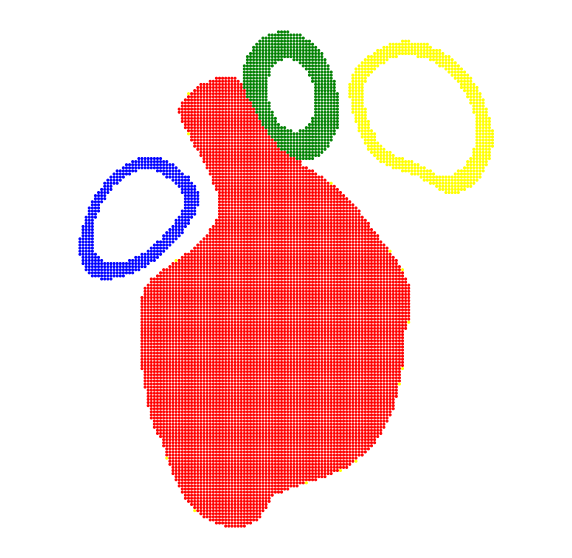

In [17]:
# assign color to regions
dh_mta_cmap = {0:"red",1:"green",2:"yellow",3:"blue"}
# create figure
plt.figure(figsize=(10,10),facecolor ="white")
# plot grid with color according to meta data
plt.scatter(dh_grid_crd[:,0],
            dh_grid_crd[:,1],
            c = [dh_mta_cmap[x] for x in dh_mta],s = 4)

# plot aesthetics
plt.axis("equal")
plt.axis("off")
plt.gca().invert_yaxis()
plt.show()

Great! Currently, the regions are just indicated by numbers, so let's update our meta data to a `pandas.DataFrame` object with some more interpretable annotations.

In [18]:
dh_mta = pd.DataFrame(dict(region_id = dh_mta))
dh_mta["region_name"] = dh_mta.region_id.map({0:"main_body",1:"outflow_tract",2:"atrium_1",3:"atrium_2"})

Now, this is what the meta data looks like:

In [19]:
dh_mta

,region_id,region_name
0,3,atrium_2
1,3,atrium_2
2,3,atrium_2
3,3,atrium_2
4,3,atrium_2
...,...,...
9861,2,atrium_1
9862,2,atrium_1
9863,2,atrium_1
9864,2,atrium_1


Finally, with all the pieces in place we can **create the *reference object***. We do this by using the `Reference` class from the `models` module in `eggplant`. The input is: the grid we created from the reference image, the landmarks that we loaded, and the meta data that we just updated.

In [20]:
dh_ref = eg.m.Reference(dh_grid_crd,
                        landmarks = dh_ref_lmk.values,
                        meta = dh_mta,
                        )

Next up is **pre-processing of the count data**. To each sections we'll apply the following sequence of operations:
1. `default_normalization`- filter and normalize the data (standard scaling, i.e., {x - mean} / std) and remove any genes present in less than `min_cell` cells.
2. `match_scales` - match scales between the reference and observed data, to make sure the length units are the same
3. `get_landmark_distances`- compute the landmark distances in the observed data.

In [21]:
for adata in dh_adatas.values():
    eg.pp.default_normalization(adata,min_cells=1)
    eg.pp.match_scales(adata,dh_ref)
    eg.pp.get_landmark_distance(adata,reference=dh_ref)



Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

We're now at a position where we can **transfer information** from the observed data to the reference, so let us define which features (genes) we want to transfer specifically. Here, the same four genes as we examined in the bioRxiv manuscript will be used.

In [22]:
DH_GENES = ["MYH6","ELN","MYH7","COL2A1"]

Before transfer the information, it's smart to inspect the feature expression in the observed data. This allows us to get an idea of what we should expect from the transfer, and to confirm that the data looks legit. 
<br>
<br>
For the inspection we use the `visualize_observed` function from the `plot` module again, but this time specifying the features to plot and not including the image (`show_image` is by default set to `False`).

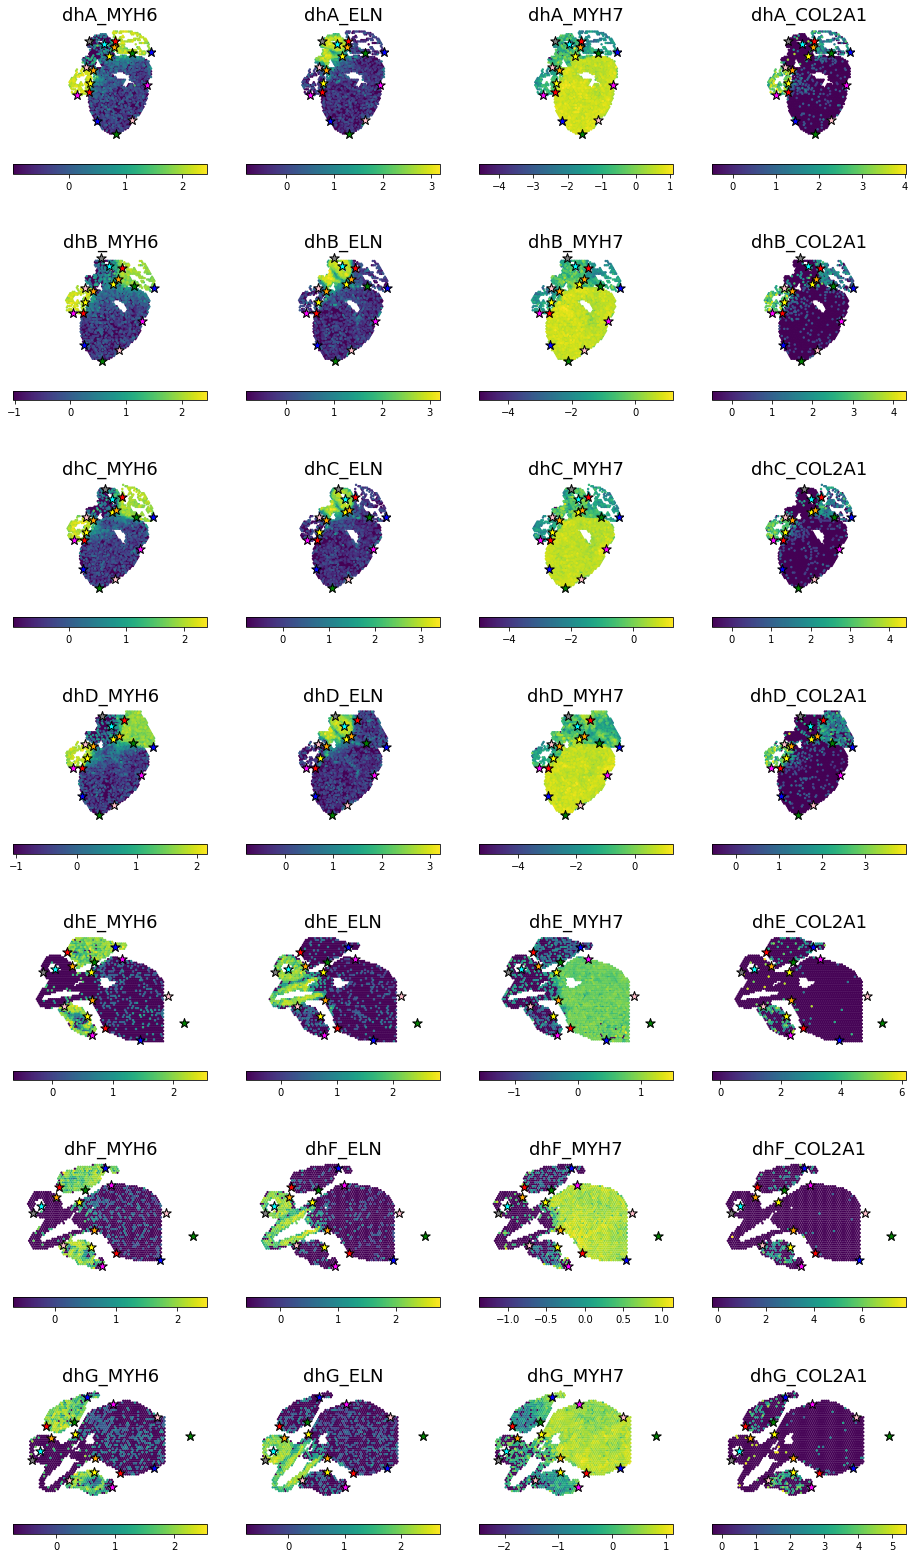

In [23]:
eg.pl.visualize_observed(dh_adatas,
                         n_cols = len(DH_GENES),
                         features = DH_GENES,
                         side_size = 4,
                         quantile_scaling = False,
                         flip_y = True,
                         show_landmarks = True,
                         marker_size = 2,
                         share_colorscale = False,
                         landmark_marker_size = 100,
                         fontsize = 18,
                         colorbar_fontsize = 10,
                         hspace = 0.4,
                         return_figures = False,
                         )


Let us now, finally, **transfer the information** from the observed data to the reference. This is done with the `transfer_to_reference` function (there's also another option, but more on that later).
<br>
<br>
**NOTE**: On a semi-old GPU, a single transfer takes ~30 seconds, so you could expect about (4 genes)x(7 sections)x(30s) ~ 15mins for the anlysis to complete. **If you prefer to not wait**, change the `DEMO` variable at the top of this notebook to `True` and you can load the pre-analyzed data. If this time-aspect feels daunting when thinking about transferring larger gene sets, we'll look at a solution that makes transfer of the full transcriptome almost as fast as this analysis.

In [24]:
dh_losses = eg.fun.transfer_to_reference(dh_adatas,
                                         features = DH_GENES,
                                         reference = dh_ref,
                                         n_epochs=(1000 if not DEMO else 10),
                                         device =DEVICE,
                                         verbose = True,
                                         return_losses = True,
                                         return_models =False,
                                         max_cg_iterations = 10000,
                                        )

[Processing] ::  Model : dhA | Feature : MYH6 | Transfer : 1/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.72it/s]


[Processing] ::  Model : dhA | Feature : ELN | Transfer : 2/28


/home/marvin/anaconda3/envs/eggplant/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.65it/s]


[Processing] ::  Model : dhA | Feature : MYH7 | Transfer : 3/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.83it/s]


[Processing] ::  Model : dhA | Feature : COL2A1 | Transfer : 4/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.69it/s]


[Processing] ::  Model : dhB | Feature : MYH6 | Transfer : 5/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.75it/s]


[Processing] ::  Model : dhB | Feature : ELN | Transfer : 6/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.11it/s]


[Processing] ::  Model : dhB | Feature : MYH7 | Transfer : 7/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.57it/s]


[Processing] ::  Model : dhB | Feature : COL2A1 | Transfer : 8/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.97it/s]


[Processing] ::  Model : dhC | Feature : MYH6 | Transfer : 9/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.69it/s]


[Processing] ::  Model : dhC | Feature : ELN | Transfer : 10/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.85it/s]


[Processing] ::  Model : dhC | Feature : MYH7 | Transfer : 11/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.12it/s]


[Processing] ::  Model : dhC | Feature : COL2A1 | Transfer : 12/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.03it/s]


[Processing] ::  Model : dhD | Feature : MYH6 | Transfer : 13/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.51it/s]


[Processing] ::  Model : dhD | Feature : ELN | Transfer : 14/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.80it/s]


[Processing] ::  Model : dhD | Feature : MYH7 | Transfer : 15/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.79it/s]


[Processing] ::  Model : dhD | Feature : COL2A1 | Transfer : 16/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.72it/s]


[Processing] ::  Model : dhE | Feature : MYH6 | Transfer : 17/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.20it/s]


[Processing] ::  Model : dhE | Feature : ELN | Transfer : 18/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.76it/s]


[Processing] ::  Model : dhE | Feature : MYH7 | Transfer : 19/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.63it/s]


[Processing] ::  Model : dhE | Feature : COL2A1 | Transfer : 20/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.06it/s]


[Processing] ::  Model : dhF | Feature : MYH6 | Transfer : 21/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.73it/s]


[Processing] ::  Model : dhF | Feature : ELN | Transfer : 22/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.91it/s]


[Processing] ::  Model : dhF | Feature : MYH7 | Transfer : 23/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.61it/s]


[Processing] ::  Model : dhF | Feature : COL2A1 | Transfer : 24/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.08it/s]


[Processing] ::  Model : dhG | Feature : MYH6 | Transfer : 25/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.04it/s]


[Processing] ::  Model : dhG | Feature : ELN | Transfer : 26/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:48<00:00, 20.79it/s]


[Processing] ::  Model : dhG | Feature : MYH7 | Transfer : 27/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.55it/s]


[Processing] ::  Model : dhG | Feature : COL2A1 | Transfer : 28/28


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.73it/s]


You don't really have to pay attention to the next cell, just execute it. If you run this notebook in demo mode, it will load the pre-analyzed data. If you're not running in demo mode, and you've set the `SAVE_OBJS` variable to `True` it will save your results.

In [ ]:
DH_OBJ_DIR = "../data/analysis/developmental-heart"
if not DEMO and SAVE_OBJS:
    if not osp.isdir(DH_OBJ_DIR):
        makedirs(DH_OBJ_DIR, exist_ok=True)
    pickle.dump(dh_losses,open(osp.join(DH_OBJ_DIR,"losses.p"),"wb"))
    dh_ref.adata.write_h5ad(osp.join(DH_OBJ_DIR,"reference.h5ad"))
elif DEMO:
    dh_losses = pickle.load(open(osp.join(DH_OBJ_DIR,"losses.p"),"rb"))
    dh_ref.adata = ad.read_h5ad(osp.join(DH_OBJ_DIR,"reference.h5ad"))

We can assess the losses of each model, to make sure they converged.

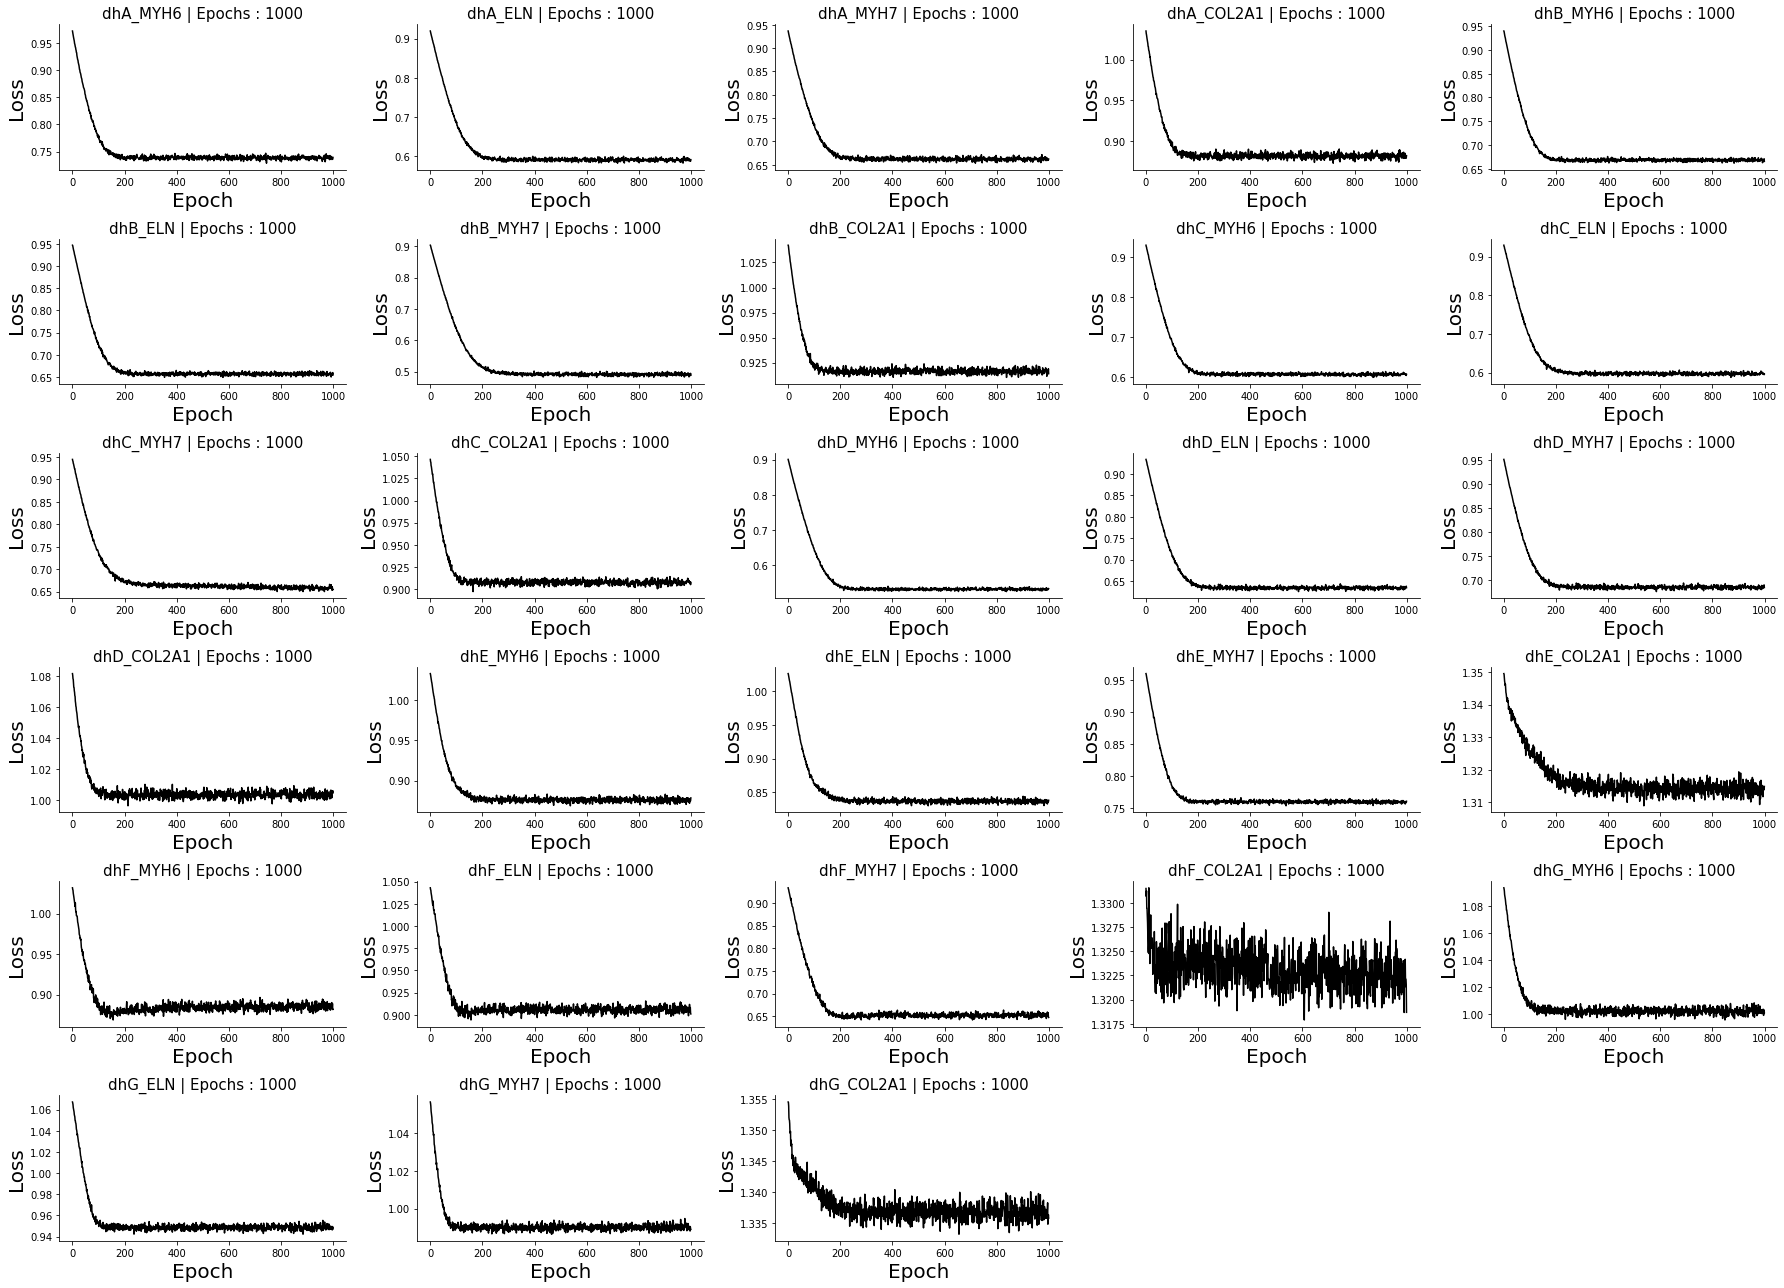

In [25]:
eg.pl.model_diagnostics(losses = dh_losses)

Given that the losses looks ok, we should have some good results! We'll **inspect the transfer** using the `visualize_transfer` function.

**Comment** : Yes, the COL2A1 gene has some less-than-clean traces, but you don't have to worry to much about this.

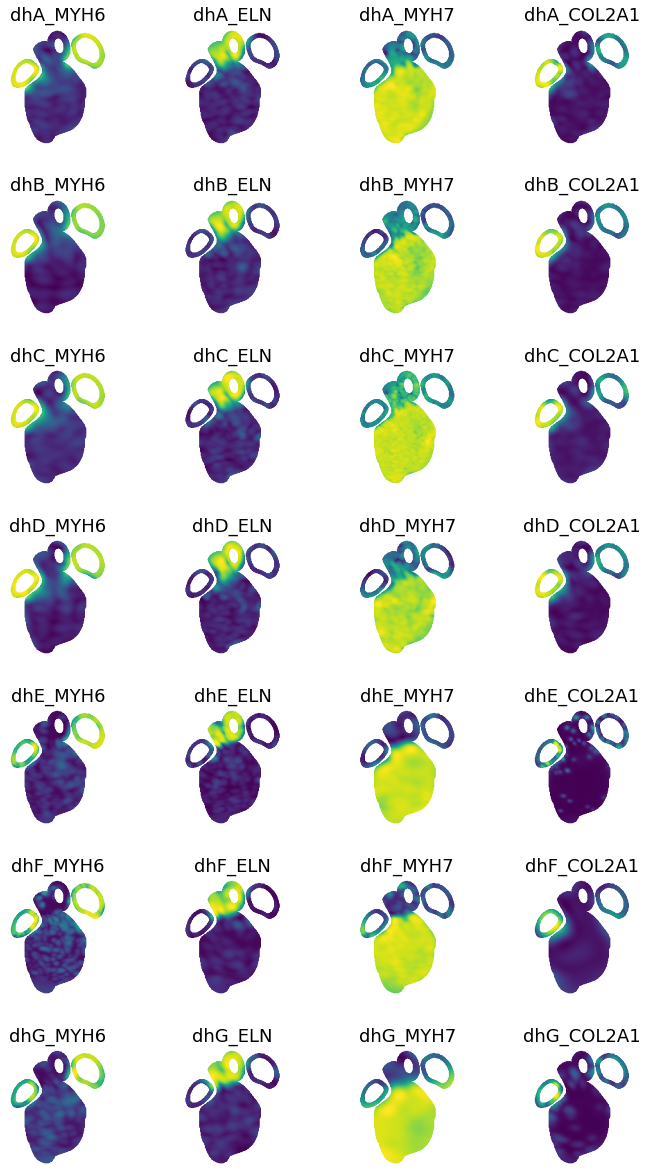

In [26]:
fig,ax = eg.pl.visualize_transfer(dh_ref,
                         n_cols = len(DH_GENES),
                         side_size = 3,
                         quantile_scaling = False,
                         flip_y = True,
                         show_landmarks = False,
                         marker_size = 1,
                         include_colorbar = False,
                         separate_colorbar = False,
                         share_colorscale = False,
                         fontsize = 18,
                         colorbar_fontsize = 10,
                         hspace = 0.4,
                         return_figures = True,
                        )

With all of these sections and genes, there's quite a lot of information to digest, we will therefore **create a composite representation** of our data, which you can think of as an average across all the different sections. We'll use the `composite_representation` method of the reference object to do this, specifying that we want a composite representation of each feature by setting `by = "feature"`.

In [27]:
dh_ref.composite_representation(by = "feature")

/home/marvin/anaconda3/envs/eggplant/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/marvin/anaconda3/envs/eggplant/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: Layer 'var' converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


We can **visualize the composite profiles** by using the `visualize_tranfer` function again, but this time setting the `attributes` argument to `"composite"` (this prevents all of the other results from also being shown). These will be a bit "blurry", but that's because we average across all the sections.

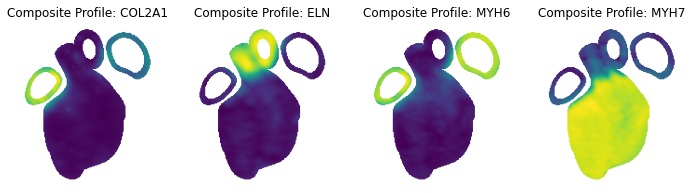

In [28]:
fig,ax = eg.pl.visualize_transfer(dh_ref,
                                  n_cols = len(DH_GENES),
                                  side_size = 3,
                                  attributes = "composite",
                                  quantile_scaling = False,
                                  flip_y = True,
                                  show_landmarks = False,
                                  marker_size = 1,
                                  include_colorbar = False,
                                  separate_colorbar = False,
                                  share_colorscale = False,
                                  fontsize = 12,
                                  colorbar_fontsize = 10,
                                  hspace = 0.4,
                                  return_figures = True,
                                 )

Revisiting the reference's annotation (coloring of different regions), we can also **assess how the genes are expressed in each of the different regions** by using the `distplot_transfer` function. We'll specify which items that should be outer (one subplot) and inner (column in each subplot), by declaring which slot (`var` or `obs`) that these items can be found as well as which column in the slot (var/obs) retreive the information from.

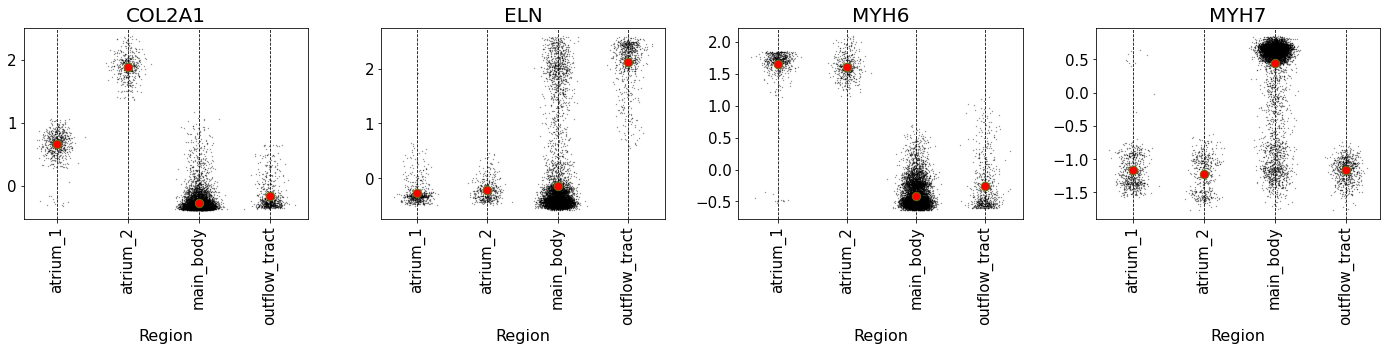

In [29]:
outside = {"attribute":"var","column":"feature"}
inside = {"attribute":"obs","column":"region_name"}

fig,ax = eg.pl.distplot_transfer(dh_ref,
                       inside,
                       outside,
                       return_figures=True,
                       n_cols = 4,
                       ticks_fontsize = 15,
                       title_fontsize = 20,
                       side_size = 5,
                       mean_marker_style={"c":"red","s":70,"marker":"o"}
                    )

for k,axx in enumerate(ax):
    axx.set_ylabel("")
    axx.set_xlabel("Region")

As you can see, there seems to be an assymmetry between the left and right atria when looking at the expression of _COL2A1_. We can assess whether this is a statistically significany difference using the `test_region_wise_enrichment` function, specifying which two regions we want to compare. A permuation test is used to compute the p-value

In [30]:
region_1 = "atrium_1"
region_2 = "atrium_2"
feature = "COL2A1"
assymetry_test = eg.sdea.test_region_wise_enrichment(data = dh_ref,
                                            feature = feature,
                                            region_1= region_1,
                                            region_2= region_2,
                                            include_models = "composite",
                                            col_name = "region_name",
                                            feature_col = "feature",
                                            alpha = 0.05,
                                            n_permutations = 1000,
                                            )

The cell below gives an interpretation of our result:

In [31]:
if assymetry_test["composite"]["is_sig"]:
    test_msg = "is"
else:
    test_msg = "is not"

print(f"{feature} {test_msg} significantly differentially expressed between the regions: {region_1} and {region_2}")


COL2A1 is significantly differentially expressed between the regions: atrium_1 and atrium_2


That's about it for the developmental heart, there's plenty of more cool stuff that we could explore, but let's move on to the perturbation set from the mouse brain instead.

## Mouse perturbation analysis

This data set comes from a previously published study by [Buzzi et al](https://doi.org/10.1016/j.freeradbiomed.2021.11.011). The tissue is a classic one: mouse brain. What's interesting with this publication is how they actually **perturb the normal state** by injection with _Heme_ as well as a _sham_ substance (saline), and study the results of this intervention. The image below is an excerpt from the original publication's Figure 1, outlining the study.


![study outline](images/mp-study-overview.png)

Although relevant, we're not particularly interested in the biology right now, but instead how this data set presents exactly the kind of scenario where a common coordinate framework is useful. <span style="color:red">**We have sections representing the same anatomical region, but from different individuals** </span>(i.e., there's some variance in spatial structure), and there are case/control data that we'd like to compare in a "spatial manner". 
<br>
<br>
To be clear, there are three cases:
- **control** : no injection, just standard mouse brain
- **heme** : injection with Heme
- **sham** : injection with a sham solution (saline)

For simplicity, we'll use one sample from each case.

**Comment** : The first steps of this analysis, loading and preparationof the count data and reference are very similar to those of the developmental heart analysis, thus the descriptions of each step will not be as elaborative as in the previous section.


Set variables (path's to data)

In [32]:
MP_DATA_DIR = "../data/mouse-perturbed/curated/"
MP_REF_DIR = "../data/mouse-perturbed/reference/"

Load the count data, also give new names to the sections ("case" instead of GEO number).

In [34]:
listdir(MP_DATA_DIR)

['GSM5519054.h5ad', 'GSM5519059.h5ad', 'GSM5519060.h5ad']

In [37]:
!conda update anndata


PackageNotInstalledError: Package is not installed in prefix.
  prefix: /home/marvin/anaconda3/envs/eggplant
  package name: anndata




In [38]:
geo_to_name = {"GSM5519054":"control","GSM5519059":"heme","GSM5519060":"sham"}
mp_adatas = {geo_to_name[p.split(".")[0]]:ad.read_h5ad(osp.join(MP_DATA_DIR,p)) for p in listdir(MP_DATA_DIR)}

AnnDataReadError: Above error raised while reading key '/layers' of type <class 'h5py._hl.group.Group'> from /.

Visualize the observed data, only image and landmarks - no feature values.

In [ ]:
eg.pl.visualize_observed(mp_adatas,
                         n_cols = len(mp_adatas),
                         features = None,
                         side_size = 4,
                         show_image = True,
                         quantile_scaling = False,
                         show_landmarks = True,
                         marker_size = 2,
                         share_colorscale = False,
                         landmark_marker_size = 100,
                         fontsize = 18,
                         colorbar_fontsize = 10,
                         hspace = 0.4,
                         return_figures = False,
                         )


As you can see, these three sections more or less **represent the same structure** but there are still some significant differences between them w.r.t. their spatial structure. This is why we'd like to cast them into the same reference, so we can compare the spatial gene expression between the different cases.<br>
<br>
**Comment** : In this analysis, we're only using _5 landmarks_, while we used more in the developmental heart analysis, this is usually sufficient to get a good characterization of the spatial gene expression.
<br>
<br>
Let us now load and inspect the reference, just as we did with the developmental heart data.

In [ ]:
# load reference image
mp_ref_img = Image.open(osp.join(MP_REF_DIR,
                              "reference.png"))

# load landmarks
mp_ref_lmk = pd.read_csv(osp.join(MP_REF_DIR,"landmarks.tsv"),
                      sep="\t",
                      header = 0,
                      index_col =0)

Plot the reference image and landmarks

In [ ]:
plt.figure(figsize = (5,5))
mp_lmk_cmap = eg.constants.LANDMARK_CMAP
mp_cmap = eg.pl.ColorMapper(mp_lmk_cmap)

plt.imshow(mp_ref_img,alpha = 0.7)
plt.scatter(mp_ref_lmk.values[:,0],
            mp_ref_lmk.values[:,1],
            marker = "*",
            edgecolor = "black",
            c = mp_cmap(mp_ref_lmk),
            s = 400,
           )

plt.axis("off")
plt.show()

Create spatial grid and meta data. This time, no regions have been annotated, so we'll let `n_regions=1`.

In [ ]:
mp_grid_crd,mp_mta = eg.pp.reference_to_grid(mp_ref_img,
                                             n_approx_points=5000,
                                             n_regions=1,
                                            )

Inspect the generated grid and how the landmarks relate to it.

In [ ]:
# plot the generated grid
plt.scatter(mp_grid_crd[:,0],
            mp_grid_crd[:,1],
            c= mp_mta,
            cmap = plt.cm.binary_r,
            s = 1,
           )

# plot the landmarks
plt.scatter(mp_ref_lmk.values[:,0],
            mp_ref_lmk.values[:,1],
            marker = "*",
            c = "red",
            s = 200,
           )

# plot aesthetics
plt.gca().invert_yaxis()
plt.axis("equal")
plt.axis("off")
plt.show()

Create a reference object from the grid, landmarks, and meta data.

In [ ]:
mp_ref = eg.m.Reference(mp_grid_crd,
                        landmarks = mp_ref_lmk.values,
                        meta = dict(region = mp_mta),
                        )

Process the count data (normalization and filtration), match scales with the reference and compute landmark distances.

In [ ]:
for adata in mp_adatas.values():
    eg.pp.default_normalization(adata,
                                min_cells = 0.0, #no filtering
                                total_counts = 1e4,
                                exclude_highly_expressed=False)
    
    eg.pp.match_scales(adata,mp_ref)
    eg.pp.get_landmark_distance(adata,
                                reference=mp_ref)

Specify which features (genes) we'd like to transfer to the reference. We'll pick three of the genes that the authors of the original publication highlight as different between the cases (in Figure 1G). The Figure below is a modified version of their Figure 1G, where I've marked the feature of interest with red (the three genes we'll analyze).

![Figure 1G](images/mp-gex-comp.png)

In [ ]:
MP_GENES = ["Serpina3n", "Cd63", "Timp1"]

Visualize the selected genes in the observed data

In [ ]:
eg.pl.visualize_observed(mp_adatas,
                         features = MP_GENES,
                         n_rows = 2,
                         include_title = True,
                         fontsize = 20,
                         marker_size =3,
                         share_colorscale = True,
                         side_size = 4,
                         n_cols = len(MP_GENES),
                         show_landmarks = False,
                         quantile_scaling = True,
                         flip_y = True,
                         colorbar_fontsize = 10.
                        )

There are some clear differences here, it would be interesting to compare the feature expression on a location-wise level, hence why `eggplant` is relevant to this data set.<br>
<br>
Let us now **transfer the information to the reference** using the `transfer_to_reference` function.

In [ ]:
mp_losses = eg.fun.transfer_to_reference(mp_adatas,
                                         reference=mp_ref,
                                         features = MP_GENES,
                                         n_epochs=(1000 if not DEMO else 10),
                                         device =DEVICE,
                                         verbose=True,
                                         )

As in the developmental heart analysis, the cell below just loads/saves data depending on your notebook settings.

In [ ]:
MP_EXACT_OBJ_DIR = "../data/analysis/mouse-perturbed/exact"
if not DEMO and SAVE_OBJS:
    if not osp.isdir(MP_EXACT_OBJ_DIR):
        makedirs(MP_EXACT_OBJ_DIR, exist_ok=True)
    pickle.dump(mp_losses,open(osp.join(MP_EXACT_OBJ_DIR,"losses.p"),"wb"))
    mp_ref.adata.write_h5ad(osp.join(MP_EXACT_OBJ_DIR,"reference.h5ad"))
else:
    mp_losses = pickle.load(open(osp.join(MP_EXACT_OBJ_DIR,"losses.p"),"rb"))
    mp_ref.adata = ad.read_h5ad(osp.join(MP_EXACT_OBJ_DIR,"reference.h5ad"))

Inspect the loss curves to ensure convergence.

In [ ]:
eg.pl.model_diagnostics(losses = mp_losses)

Confirming that everyting looks good, we next **visualize the transferred information** using the `visualize_transfer` function from the `plot` module.

In [ ]:
eg.pl.visualize_transfer(mp_ref,
                         n_cols = 3,
                         attributes = MP_GENES,
                         include_title = True,
                         fontsize = 15,
                         marker_size =3,
                         share_colorscale = True,
                         separate_colorbar = False,
                         colorbar_fontsize = 20,
                         side_size = 6,
                         show_landmarks = False,
                         flip_y = True,
                         quantile_scaling = False,
                        )

What we've done so far is very similar to the developmental heart analysis, but what the next step intorduces a new element: a  **comparison of the spatial feature expression** between the different conditions. This is what we refer to as <span style="color:red">**spatial differential expression analysis**</span> or **SDEA** for short (which builds on the concept of _spatial arithmetics_).<br>
<br>
You can specify which feature you want to assess by setting the variable `compare_feature = "feature_of_interest"` (default: `feature_of_interest = "Serpina3n"`). To execute the analysis, we then use the `sdea` function from the `sdea` module of `eggplant`. <br>
<br>
We subset the transferred information (found in `mp_ref.adata`) to only include the transferred information corresponding to our feature of interest. With `group_col="model"` we indicate that features expression should be compared across the different models (conditions). Finally, with `n_std` we state that for expression in a point to be considered differentially expressed between two conditions, the feature expression envelopes of $\textrm{mean} \pm \textrm{n_std}\times \sigma$ for each condition must not overlap. For a more detailed explanation of the sdea, I would refer to the preprint.

In [ ]:
compare_feature = "Serpina3n"
sdea_res = eg.sdea.sdea(mp_ref.adata[:,mp_ref.adata.var.feature.values == compare_feature],
                        group_col="model",
                        n_std=2,
                       )

We can **visualize our SDEA results** by using the function `visualize_sdea_results`.

In [ ]:
eg.pl.visualize_sdea_results(mp_ref,
                             sdea_res,
                             n_cols = 3,
                             marker_size = 8,
                             side_size = 6,
                             colorbar_orientation ="horizontal",
                             title_fontsize = 20,
                             colorbar_fontsize = 10,
                             no_sig_color = "darkgray",
                             reorder_axes = [0,2,1],
                             )

You'll see three different plots above, comparing the feature expression of the `feature_of_interest` between the different combination of cases. For the pair $\Delta(a,b)$ blue color indicates that $a$ is upregulated at a position compared to $b$, while the opposite is true for red.<br>
<br>
This _highlights_ the differences between, for example, the _heme_ and _sham_ case - where the expression in the former is less concentrated than in the latter.<br>
<br>
You can, of course, you devote more time to this kind of analysis - so feel free to explore it on your own. However, as final part of this tutorial, we'll have a look at something I've chosen to call **fast approximate transfer**.

### Fast approximate transfer

So far, we've transferred a select set of genes, where each transfer has been relatively fast - but if it was to be repeated for every gene, a time of 30s is way too much. To address this issue, there's an *alternative transfer function* that can be used. The transfer it implements scales extremely well w.r.t. the number of genes, actually it's O(1). This transfer is "_fast approximate transfer_". However, this nice scaling property comes at the cost of exactness, and the result will only be an _approximation_ of the true spatial distribution in the reference.<br>
<br>
*For the interested*:<br>
The fast approximate transfer first projects the feature values from the high-dimensional (e.g., ~20'000 dimensions if gene expression) into a low K-dimensional space, essentially compressing the data. Next, contributions from each component building up the low-dimensional space is transferred to the reference. Finally, the complete full-dimensional data is reconstructed in the reference, once all the components have been transferred.

To explore the _fast approximate transfer_ feature, we'll create a new reference object using the same input as for the exact transfer.

In [ ]:
mp_fa_ref = eg.m.Reference(mp_grid_crd,
                           landmarks = mp_ref_lmk.values,
                           meta = dict(region = mp_mta),
                          )

To transfer data using the *fast approximate* strategy, we'll use the function `fa_transfer_to_reference`. Superficially, it works in the same way as the standard `transfer_to_reference` - only difference being that instead of specifying which features you want to transfer, you specify the number of components using the `n_components` argument. 
<br>
<br>
The more components you use, the more accurate the transfer will be (though with diminishing effect). Unfortunately, the more components you use, the slower the transfer will be. In this analysis we'll use 25 components.
<br>
<br>
As a _proof of concept_ we'll only transfer information from the _Heme_ section to the reference, but you could just as well transfer data from all three cases.

In [ ]:
mp_fa_losses = eg.fun.fa_transfer_to_reference({"heme":mp_adatas["heme"]},
                                               reference=mp_fa_ref,
                                               n_components = 25,
                                               n_epochs=(1000 if not DEMO else 10),
                                               device =DEVICE,
                                               verbose=True,
                                              )

Again, the cell below simply loads/saves data depending on your notebook settings.

In [ ]:
MP_FA_OBJ_DIR = "../data/analysis/mouse-perturbed/fa"
if SAVE_OBJS:
    if not osp.isdir(FA_OBJ_DIR):
        makedirs(MP_FA_OBJ_DIR, exist_ok=True)
    pickle.dump(mp_fa_losses,open(osp.join(MP_FA_OBJ_DIR,"losses.p"),"wb"))
    mp_fa_ref.adata.write_h5ad(osp.join(MP_FA_OBJ_DIR,"reference.h5ad"))
else:
    mp_fa_losses = pickle.load(open(osp.join(MP_FA_OBJ_DIR,"losses.p"),"rb"))
    mp_fa_ref.adata = ad.read_h5ad(osp.join(MP_FA_OBJ_DIR,"reference.h5ad"))

Now, since we've transferred the whole transcriptome - we can plot any feature of our choice. As an example, we'll visualize six arbitrarily chosen genes in the reference.

In [ ]:
FA_GENES = ["Cst3","C1qa","Gfap","S100a10","Acta2","Cdkn1a"]

In [ ]:
eg.pl.visualize_transfer(mp_fa_ref,
                         n_cols = len(FA_GENES),
                         attributes = FA_GENES,
                         include_title = True,
                         fontsize = 15,
                         marker_size =3,
                         share_colorscale = True,
                         separate_colorbar = False,
                         colorbar_fontsize = 20,
                         side_size = 6,
                         show_landmarks = False,
                         flip_y = True,
                         quantile_scaling = False,
                        )

And that's about it, this is a _very_ brief introduction to `eggplant`. For any questions feel free to contact me at: _alma.andersson@differentiable.net_ or, preferably, open an issue on [github](https://github.com/almaan/eggplant).